<a href="https://colab.research.google.com/github/jeyanthan-gj/MEPCO-TRAINING/blob/main/Paper_1_Unit_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UNIT-III

**One task per cell**  


---

## List of Hands-on Experiments:
1. Fine-tuning ResNet and MobileNet  
2. Object detection with YOLOv8  
3. U-Net for crack segmentation  

## List of Assignments:
1. Fine-tune ResNet/MobileNet for defect classification  
2. Train YOLOv5 on product imagery  
3. U-Net crack segmentation


## 1. Fine-tuning ResNet and MobileNet

# **a)ResNet**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

import numpy as np
from tensorflow.keras.preprocessing import image

print("TensorFlow version:", tf.__version__)



TensorFlow version: 2.19.0


In [ ]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.cifar10.load_data()

# Normalize images
x_train = x_train.astype("float32") / 255.0
x_val = x_val.astype("float32") / 255.0


In [ ]:
resize_layer = tf.keras.Sequential([
    layers.Resizing(224, 224)
])

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32).map(lambda x, y: (resize_layer(x), y))
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(32).map(lambda x, y: (resize_layer(x), y))


In [ ]:
base_resnet = tf.keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

In [ ]:
base_resnet.trainable = False  # freeze backbone

resnet_model = models.Sequential([
    base_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")  # CIFAR-10 has 10 classes
])


In [ ]:
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
print("Training ResNet50...")
resnet_model.fit(train_ds, validation_data=val_ds, epochs=1)

Training ResNet50...
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 185s 110ms/step - accuracy: 0.1065 - loss: 2.3687 - val_accuracy: 0.1237 - val_loss: 2.2940


In [ ]:
#Test with sample image
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = "cat.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # batch dimension

pred_probs = resnet_model.predict(img_array)
pred_class = np.argmax(pred_probs, axis=1)[0]

print("Predicted class:", pred_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted class: 7


In [ ]:
# -------------------------------------
# Fine-tuning (unfreeze last few layers)
# -------------------------------------
base_resnet.trainable = True
for layer in base_resnet.layers[:-30]:
    layer.trainable = False

resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # lower LR
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("Fine-tuning ResNet50...")
resnet_model.fit(train_ds, validation_data=val_ds, epochs=1)


Fine-tuning ResNet50...
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 252s 148ms/step - accuracy: 0.3242 - loss: 1.8744 - val_accuracy: 0.4674 - val_loss: 1.5198


In [ ]:
#Test with sample image(after fine-tuning)
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = "cat.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # batch dimension

pred_probs = resnet_model.predict(img_array)
pred_class = np.argmax(pred_probs, axis=1)[0]

print("Predicted class:", pred_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: 3


# **b)MobileNet**

In [ ]:
base_mobilenet = tf.keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_mobilenet.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
mobilenet_model = models.Sequential([
    base_mobilenet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"), #hidden layer
    layers.Dropout(0.5),#50% neurons are not listening
    layers.Dense(10, activation="softmax")  # CIFAR-10 has 10 classes
])

In [ ]:
mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
print("Training mobilenet...")
mobilenet_model.fit(train_ds, validation_data=val_ds, epochs=1)

Training mobilenet...
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 97s 51ms/step - accuracy: 0.5397 - loss: 1.3687 - val_accuracy: 0.7749 - val_loss: 0.6552


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = "/content/cat.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # batch dimension

pred_probs = mobilenet_model.predict(img_array)
pred_class = np.argmax(pred_probs, axis=1)[0]

print("Predicted class:", pred_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Predicted class: 3


In [ ]:
base_mobilenet.trainable = True
for layer in base_mobilenet.layers[:-30]:
    layer.trainable = False

mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # lower LR
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("Fine-tuning MobileNet...")
mobilenet_model.fit(train_ds, validation_data=val_ds, epochs=1)

Fine-tuning MobileNet...
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 101s 54ms/step - accuracy: 0.6870 - loss: 0.9254 - val_accuracy: 0.8168 - val_loss: 0.5311


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = "/content/cat.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # batch dimension

pred_probs = mobilenet_model.predict(img_array)
pred_class = np.argmax(pred_probs, axis=1)[0]

print("Predicted class:", pred_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: 3


# 2. Object detection with YOLOv8  

In [ ]:
# ===============================
# 📦 Environment Setup for YOLOv8
# ===============================

# Install required libraries
!pip install ultralytics opencv-python matplotlib pandas tqdm -q

# Verify installation
import ultralytics
ultralytics.checks()


Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.1/112.6 GB disk)


In [ ]:


from ultralytics import YOLO

# Load baseline YOLOv8s (small version)
model = YOLO('yolov8l.pt')
results = model.train(
    data='/content/VisDrone.yaml',  # Dataset config
    epochs=1,                      # Train for 1 epochs
    imgsz=640,                      # Image size
    batch=16,                       # Batch size
    name='baseline_yolov8',         # Run name
    project='/content/runs',        # Save location
    workers=2,                      # Fewer workers (for Colab stability)
    device=0                        # Use GPU
)

# Display summary of training results
results


Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/VisDrone.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline_yolov8, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=1

Converting /content/datasets/VisDrone/VisDrone2019-DET-train: 6471it [00:42, 152.18it/s]
Converting /content/datasets/VisDrone/VisDrone2019-DET-val: 548it [00:07, 77.57it/s]
Converting /content/datasets/VisDrone/VisDrone2019-DET-test-dev: 1610it [00:10, 153.00it/s]

Dataset download success ✅ (98.3s), saved to /content/datasets



Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytic

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bccc1f76960>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

In [ ]:
# Evaluate on test dataset
metrics = model.val(
    data='VisDrone.yaml',
    split='test',
    batch=16,
    imgsz=640,
    plots=True
)

# Get main metrics using mean_results()
# Returns (precision, recall, mAP50, mAP50-95)
precision, recall, mAP50, mAP5095 = metrics.mean_results()
main_metrics = {
    'precision': precision,
    'recall': recall,
    'mAP50': mAP50,
    'mAP50-95': mAP5095
}

print("\nBaseline YOLOv8 Test Metrics:\n", main_metrics)


Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,614,318 parameters, 0 gradients, 164.9 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 56.0±22.3 MB/s, size: 199.2 KB)
val: Scanning /content/datasets/VisDrone/VisDrone2019-DET-test-dev/labels... 1610 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1610/1610 450.5it/s 3.6s
val: New cache created: /content/datasets/VisDrone/VisDrone2019-DET-test-dev/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 101/101 1.9it/s 54.4s
                   all       1610      75102      0.297      0.241      0.193       0.11
            pedestrian       1197      21006      0.392      0.212      0.216      0.089
                people        797       6376      0.444     0.0388     0.0743     0.0241
               bicycle        377       1302      0.191     0.0307     0.0447     0.0179
                


image 1/1 /content/datasets/VisDrone/VisDrone2019-DET-test-dev/images/9999952_00000_d_0000209.jpg: 384x640 5 cars, 1 van, 4 trucks, 54.6ms
Speed: 4.0ms preprocess, 54.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


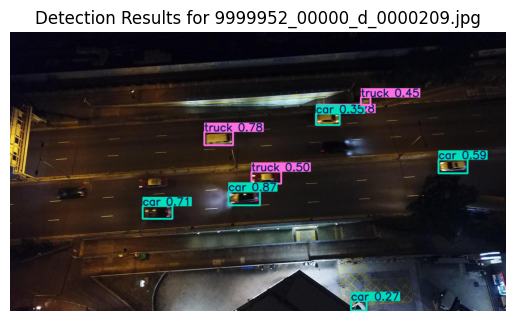


image 1/1 /content/datasets/VisDrone/VisDrone2019-DET-test-dev/images/9999952_00000_d_0000139.jpg: 384x640 4 cars, 3 trucks, 2 buss, 39.8ms
Speed: 4.2ms preprocess, 39.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


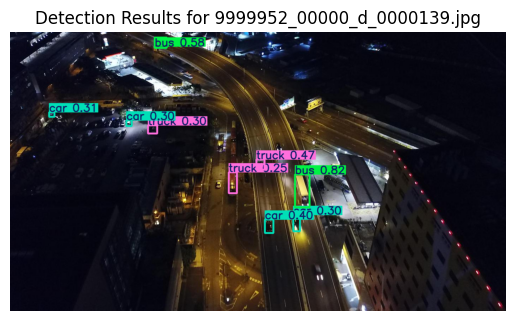


image 1/1 /content/datasets/VisDrone/VisDrone2019-DET-test-dev/images/9999938_00000_d_0000379.jpg: 384x640 14 cars, 17 trucks, 4 buss, 39.8ms
Speed: 3.5ms preprocess, 39.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


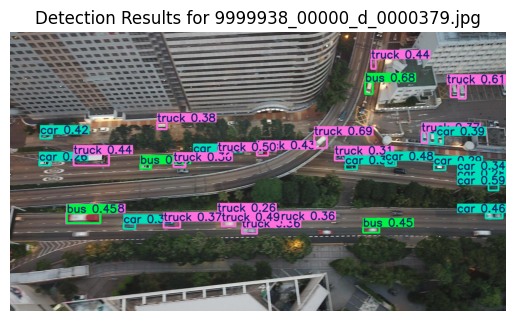


image 1/1 /content/datasets/VisDrone/VisDrone2019-DET-test-dev/images/0000265_03000_d_0000007.jpg: 384x640 12 pedestrians, 57 cars, 6 vans, 4 trucks, 3 tricycles, 3 motors, 39.9ms
Speed: 3.6ms preprocess, 39.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


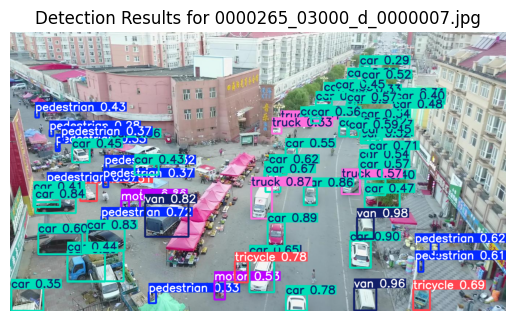


image 1/1 /content/datasets/VisDrone/VisDrone2019-DET-test-dev/images/9999938_00000_d_0000276.jpg: 384x640 9 cars, 1 van, 4 trucks, 1 bus, 39.9ms
Speed: 4.2ms preprocess, 39.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


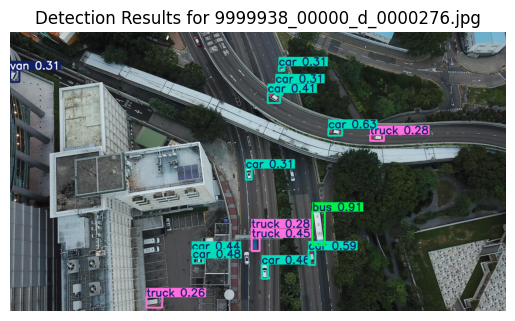

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Get the path to the test images directory from the data config
# Correcting the path to point to the correct location
test_images_dir = os.path.join("/content", data_config['path'].lstrip('../'), data_config['test'])


# Get a list of sample test image paths (e.g., first 5 images)
# Assuming the test directory contains image files directly
sample_image_paths = [os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir)[:5]]

# Run inference on the sample images and display results
for img_path in sample_image_paths:
    results = model(img_path)  # Perform inference

    # Iterate through results and draw bounding boxes
    for r in results:
        im_array = r.plot()  # plot a BGR numpy array of predictions
        im = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)  # convert to RGB
        plt.imshow(im)
        plt.axis('off')
        plt.title(f"Detection Results for {os.path.basename(img_path)}")
        plt.show()

In [ ]:
import pandas as pd

# class_result(i) gives metrics for class i: precision, recall, mAP50, mAP50-95
class_metrics_list = []
for i, name in metrics.names.items():
    p, r, m50, m5095 = metrics.class_result(i)
    class_metrics_list.append({
        'class': name,
        'precision': p,
        'recall': r,
        'mAP50': m50,
        'mAP50-95': m5095
    })

class_metrics = pd.DataFrame(class_metrics_list)
print("\nPer-Class Metrics:\n", class_metrics)



Per-Class Metrics:
              class  precision    recall     mAP50  mAP50-95
0       pedestrian   0.392064  0.212177  0.215797  0.088996
1           people   0.443784  0.038792  0.074273  0.024071
2          bicycle   0.190565  0.030722  0.044721  0.017928
3              car   0.591535  0.526010  0.556213  0.344796
4              van   0.339511  0.283313  0.251215  0.163130
5            truck   0.071934  0.386988  0.131442  0.082826
6         tricycle   0.095784  0.209434  0.063203  0.031703
7  awning-tricycle   0.231715  0.075125  0.065071  0.037079
8              bus   0.262061  0.471810  0.372800  0.259684
9            motor   0.350734  0.174337  0.154908  0.054529
